In [1]:
import os
import sys
import time
import calendar
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import scipy as sp
from scipy import stats
# import tensorflow as tf

In [2]:
from scipy.stats import wasserstein_distance

In [3]:
gen_ds_file = "generated_data/h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv"
fgen_file = "generated_data/f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv"
tg_file = "generated_data/h-gtg_0-hd_24-nl_4-bs_32--len_80.csv"


gen_df = pd.read_csv(gen_ds_file, parse_dates=["date"])
gen_df["datetime"] = gen_df["date"]
gen_df


real_df = pd.read_csv(f"real_data/final_df--czech.csv", parse_dates=["datetime"])
real_df["days_passed"] = real_df["td"]

real_df["Amount"] = real_df.amount
real_df.amount = real_df.amount.apply(abs)

fgen_df = pd.read_csv(fgen_file, parse_dates=["datetime"])
fgen_df["tcode"] = fgen_df.tcode.apply(lambda x: x.replace("---", "--"))


tg_df = pd.read_csv(tg_file, parse_dates=['datetime'])
tg_df["days_passed"] = tg_df["td"]
tg_df



,k_symbol_num,operation_num,type_num,td,amount,age,account_id,datetime,k_symbol,operation,type,tcode,raw_amount,days_passed
0,0,2,0,4.0,104.25,44.0,0,1996-04-17,NaN,NaN,CREDIT,nan__nan__CREDIT,104.25,4.0
1,0,3,1,18.0,288.76,44.0,0,1996-05-05,NaN,CASH WITHDRAWAL,DEBIT,nan__CASH WITHDRAWAL__DEBIT,-288.76,18.0
2,1,2,0,4.0,81.29,44.0,0,1996-05-09,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,81.29,4.0
3,0,0,0,9.0,14286.56,44.0,0,1996-05-18,NaN,CREDIT IN CASH,CREDIT,nan__CREDIT IN CASH__CREDIT,14286.56,9.0
4,0,4,1,-1.0,3936.29,44.0,0,1996-05-17,NaN,REMITTANCE TO ANOTHER BANK,DEBIT,nan__REMITTANCE TO ANOTHER BANK__DEBIT,-3936.29,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,1,2,0,15.0,100.05,44.0,4999,1997-05-27,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,100.05,15.0
399996,1,2,0,5.0,17.60,44.0,4999,1997-06-01,INTEREST CREDITED,NaN,CREDIT,INTEREST CREDITED__nan__CREDIT,17.60,5.0
399997,2,3,1,2.0,0.24,44.0,4999,1997-06-03,PAYMENT ON STATEMENT,CASH WITHDRAWAL,DEBIT,PAYMENT ON STATEMENT__CASH WITHDRAWAL__DEBIT,-0.24,2.0
399998,1,3,0,2.0,0.41,44.0,4999,1997-06-05,INTEREST CREDITED,CASH WITHDRAWAL,CREDIT,INTEREST CREDITED__CASH WITHDRAWAL__CREDIT,0.41,2.0


In [4]:
for df in [gen_df, tg_df, fgen_df]:

    df["month"] = df["datetime"].dt.month
    df["day"]   = df["datetime"].dt.day
    df["dow"]  =  df["datetime"].dt.dayofweek
    df["year"]  = df["datetime"].dt.year

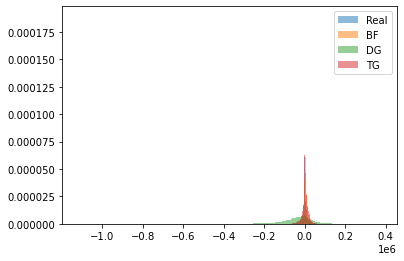

,real,gen,dg,tg,diff_bf,diff_dg,diff_tg
count,185057.000000,71782.000000,2.461300e+04,64709.000000,113275.000000,1.604440e+05,120348.000000
mean,1065.354397,3654.628391,-3.780130e+04,1585.318238,-2589.273993,3.886665e+04,-519.963841
std,12509.136299,11690.148568,8.425977e+04,17071.194344,818.987731,-7.175063e+04,-4562.058045
min,-101550.300000,-80535.840000,-1.123743e+06,-152143.310000,-21014.460000,1.022193e+06,50593.010000
25%,-2266.600000,-1628.915000,-7.459092e+04,-4434.450000,-637.685000,7.232432e+04,2167.850000
50%,1058.100000,2759.640000,-2.735912e+04,105.840000,-1701.540000,2.841722e+04,952.260000
75%,4132.200000,8431.330000,8.058819e+03,10958.280000,-4299.130000,-3.926619e+03,-6826.080000
max,115038.200000,121087.150000,3.802634e+05,82362.750000,-6048.950000,-2.652252e+05,32675.450000


In [5]:
### monthly cash flow by account

# gb = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"], as_index=False)["raw_amount"].sum()

# plt.hist(gb.raw_amount, bins="auto")
# plt.show()

# gb = gen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

# plt.hist(gb.raw_amount, bins="auto")
# plt.show()

# plt.figure(figsize=(12,4))




gbr = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbg = gen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbfg = fgen_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
gbtg = tg_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

plt.hist(gbr.raw_amount, bins="auto", label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins="auto", label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins="auto", label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins="auto", label="TG", density=True, alpha=0.5)


plt.legend()
plt.show()

df = pd.DataFrame.from_dict({"real": gbr.raw_amount.describe(),
                             "gen": gbg.raw_amount.describe(),
                             "dg": gbfg.raw_amount.describe(),
                             "tg": gbtg.raw_amount.describe(),
                            
                            })
df["diff_bf"] = df.real - df.gen
df["diff_dg"] = df.real - df.dg
df["diff_tg"] = df.real - df.tg
df

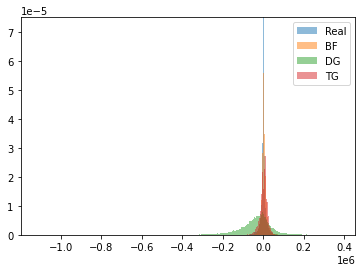

In [6]:
plt.hist(gbr.raw_amount, bins="auto", label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins="auto", label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins="auto", label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins="auto", label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

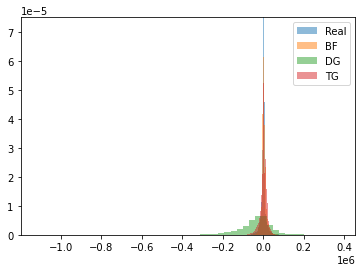

In [7]:
plt.hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins=50, label="BF", density=True, alpha=0.5)
plt.hist(gbfg.raw_amount, bins=50, label="DG", density=True, alpha=0.5)
plt.hist(gbtg.raw_amount, bins=50, label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

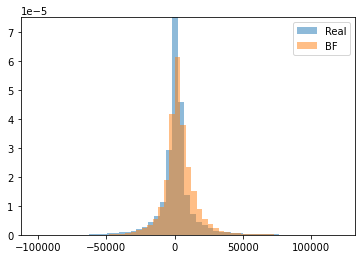

In [8]:


plt.hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
plt.hist(gbg.raw_amount, bins=50, label="BF", density=True, alpha=0.5)
# plt.hist(gbfg.raw_amount, bins=50, label="DG", density=True, alpha=0.5)
# plt.hist(gbtg.raw_amount, bins=50, label="TG", density=True, alpha=0.5)

plt.ylim([0.0, 0.000075])

plt.legend()
plt.show()

In [9]:
from scipy.stats import wasserstein_distance

In [22]:
!pwd

/Users/kylenickerson/Desktop/verafin_proj_big/ecmlkdd/code/metrics-final


##### fig

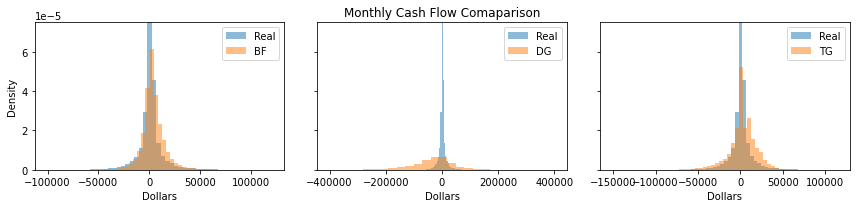

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,3), 
                       # sharex=True, 
                       sharey=True)

# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])
# ax[3].set_ylim([-5,5])
# ax[3].set_xlim([-5,5])

for i, (vals, lbl) in enumerate([(gbg, "BF"), (gbfg, "DG"), (gbtg, "TG")]):
    
    
    ax[i].hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
    ax[i].set_ylim([0.0, 0.000075])
    
    if i==1:
        ax[i].set_xlim([-10e5/2.25, 10e5/2.25])
        
    ax[i].legend()
    
    wd = wasserstein_distance(gbr.raw_amount, vals.raw_amount)
    # print("Wasserstein between real and", lbl, "is", wd)
    
ax[1].set_title("Monthly Cash Flow Comaparison")

ax[0].set_ylabel("Density")

ax[0].set_xlabel("Dollars")
ax[1].set_xlabel("Dollars")
ax[2].set_xlabel("Dollars")
    
# plt.legend()
plt.tight_layout()
plt.savefig("figs/cash_flow_cz.png")
plt.show()

Wasserstein between real and BF is 2738.720419510724
Wasserstein between real and DG is 57800.05021510121
Wasserstein between real and TG is 4980.963992803339


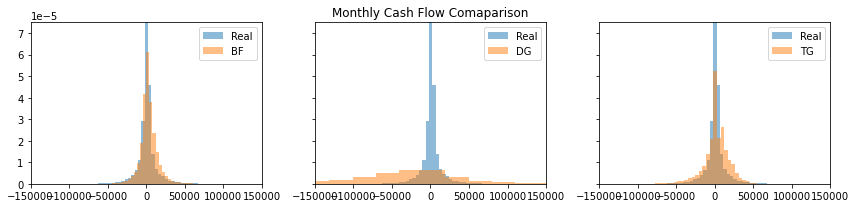

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,3), 
                       # sharex=True, 
                       sharey=True)

# ax[0].set_ylim([-5,5])
# ax[0].set_xlim([-5,5])
# ax[1].set_ylim([-5,5])
# ax[1].set_xlim([-5,5])
# ax[2].set_ylim([-5,5])
# ax[2].set_xlim([-5,5])
# ax[3].set_ylim([-5,5])
# ax[3].set_xlim([-5,5])

for i, (vals, lbl) in enumerate([(gbg, "BF"), (gbfg, "DG"), (gbtg, "TG")]):
    
    
    ax[i].hist(gbr.raw_amount, bins=50, label="Real", density=True, alpha=0.5)
    ax[i].hist(vals.raw_amount, bins=50, label=lbl, density=True, alpha=0.5)
    ax[i].set_ylim([0.0, 0.000075])
    ax[i].set_xlim([-10e4*1.5, 10e4*1.5])
    ax[i].legend()
    
    wd = wasserstein_distance(gbr.raw_amount, vals.raw_amount)
    print("Wasserstein between real and", lbl, "is", wd)
    
ax[1].set_title("Monthly Cash Flow Comaparison")
    
# plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# for fname in [
#  'h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
#  'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#  'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
#  'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
#     ]:

for fname in [
    'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
 'f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
    ]:
    
    # print(fname)
    
    gdf = pd.read_csv("generated_data/" + fname, parse_dates=['datetime'])
    
    
    
    gdf["month"] = gdf["datetime"].dt.month
    gdf["day"]   = gdf["datetime"].dt.day
    gdf["dow"]  =  gdf["datetime"].dt.dayofweek
    gdf["year"]  = gdf["datetime"].dt.year


# gbr = real_df[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()
    gbg = gdf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

    wd = wasserstein_distance(gbr.raw_amount, gbg.raw_amount)
    print(wd)
    # print("Wasserstein between real is", wd, "\n\n")
    
    

2738.720419510724
4191.260127452959
4775.233584873214
4138.9269155801985
4980.963992803339
57800.05021510121


# New - joint dom, tcode

In [13]:
real_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'column_a', 'account_id', 'date', 'type',
       'operation', 'amount', 'balance', 'k_symbol', 'age', 'tcode',
       'datetime', 'month', 'day', 'dow', 'year', 'td', 'dtme', 'doy',
       'raw_amount', 'days_passed', 'Amount'],
      dtype='object')

In [14]:
fgen_df.columns

Index(['Unnamed: 0', 'unnamed: 0', 'tcode', 'amount', 'balance', 'age', 'dif',
       'account_id', 'date', 'date.1', 'cum_dif', 'days_passed', 'short_tcode',
       'raw_tcode', 'k_symbol', 'operation', 'type', 'datetime', 'raw_amount',
       'month', 'day', 'dow', 'year'],
      dtype='object')

In [15]:
# Creates dataframe with ngram counts.
def create_ngramcount_df(df, n, field):
    gb = df.sort_values(by=["account_id", "datetime"]).groupby("account_id", sort=False)[field]
    ngram_list = gb.apply(lambda x: list(ngrams(x, n=n)))

    counts = {}
    for ngram_seq in ngram_list:
        for ngram in ngram_seq:
            ngram = str(ngram)[1:-1]
            counts[ngram] = counts.get(ngram, 0) + 1
            
            
    df = pd.DataFrame.from_dict(counts, orient="index", columns=["counts"]).sort_values("counts", ascending=False)
    
            
    return df.reset_index().rename(columns={"index": "ngram"})



In [16]:
for df in [gen_df, fgen_df, tg_df]:
    break
    
    

In [17]:
def set_tcode_day(df):
    df['tcode_day'] = df.tcode + "---" + df.day.astype(str)
    


In [21]:
from scipy.special import rel_entr

n=1

set_tcode_day(real_df)

field = 'tcode_day'
real_ngrams = create_ngramcount_df(real_df, n, field)

for df in [gen_df, fgen_df, tg_df]:
    
    set_tcode_day(df)
    
    uniq_r = list((real_df.tcode + "---" + real_df.day.astype(str)).unique())
    uniq_g = list((df.tcode      + "---" + df.day.astype(str)).unique())
    
    n_codes_unique = len(set(uniq_r + uniq_g))

    
    # create combo_df, which contains counts of all ngrams for both datasets (note: it omits any ngrams which do not occur in either dataset)
    gen_ngrams = create_ngramcount_df(df, n, field)
    combo_df = pd.merge(real_ngrams, gen_ngrams, on="ngram", how="outer", suffixes=("_real", "_gen")).fillna(0.0)
    

    N_obs_real = real_ngrams["counts"].sum()
    N_obs_gen = gen_ngrams["counts"].sum()
    N_possible_ngrams = n_codes_unique**n 

    
    # set ps
    combo_df["ps_real"] = combo_df["counts_real"] / N_obs_real 
    combo_df["ps_gen"] = combo_df["counts_gen"] / N_obs_gen 
    

        
        
    # compute jsd (note: contribution to jsd from any ngram not in either dataset is 0)
    combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2
    kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"])) 
    kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))

    jsd = (kl_real_M + kl_gen_M)/2
    
    print(jsd)
        

NameError: name 'ngrams' is not defined

In [20]:


for fname in [
    'h-gen_v2b__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-nd__nld_4-dm_128-nh_2-i_2-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-nc__nld_4-dm_128-nh_2-i_1-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gen_v2b-v__nld_4-dm_128-nh_2-i_0-dr_0__1-opt_adam-lwi_0-bs_64--vf1-len_80-v2.csv',
 'h-gtg_0-hd_24-nl_4-bs_32--len_80.csv',
 'f-czech-700__epoch-1000_bs-200_lr-g0005-d0005-a0005_epoch_id-299.csv',
    ]:
    
    # print(fname)
    
    df = pd.read_csv("generated_data/" + fname, parse_dates=['datetime'])
    
    
    
    df["month"] = df["datetime"].dt.month
    df["day"]   = df["datetime"].dt.day
    df["dow"]  =  df["datetime"].dt.dayofweek
    df["year"]  = df["datetime"].dt.year

    
    
  
    set_tcode_day(df)
    
    uniq_r = list(real_df.tcode_day.unique())
    uniq_g = list(df.tcode_day.unique())
    
    n_codes_unique = len(set(uniq_r + uniq_g))

    
    # create combo_df, which contains counts of all ngrams for both datasets (note: it omits any ngrams which do not occur in either dataset)
    gen_ngrams = create_ngramcount_df(df, 1, field)
    combo_df = pd.merge(real_ngrams, gen_ngrams, on="ngram", how="outer", suffixes=("_real", "_gen")).fillna(0.0)
    

    N_obs_real = real_ngrams["counts"].sum()
    N_obs_gen = gen_ngrams["counts"].sum()
    N_possible_ngrams = n_codes_unique**n 

    
    # set ps
    combo_df["ps_real"] = combo_df["counts_real"] / N_obs_real 
    combo_df["ps_gen"] = combo_df["counts_gen"] / N_obs_gen 
    

        
        
    # compute jsd (note: contribution to jsd from any ngram not in either dataset is 0)
    combo_df["ps_mid"] = (combo_df["ps_real"] + combo_df["ps_gen"])/2
    kl_real_M = sum(rel_entr(combo_df["ps_real"], combo_df["ps_mid"])) 
    kl_gen_M = sum(rel_entr(combo_df["ps_gen"], combo_df["ps_mid"]))

    jsd = (kl_real_M + kl_gen_M)/2
    
    print(f"{jsd:0.3f}")
        


NameError: name 'n' is not defined

# End new

In [25]:
fgen_df.columns

Index(['Unnamed: 0', 'unnamed: 0', 'tcode', 'amount', 'balance', 'age', 'dif',
       'account_id', 'date', 'date.1', 'cum_dif', 'days_passed', 'short_tcode',
       'raw_tcode', 'k_symbol', 'operation', 'type', 'datetime', 'raw_amount',
       'month', 'day', 'dow', 'year'],
      dtype='object')

In [25]:
fgen_df.columns

Index(['Unnamed: 0', 'unnamed: 0', 'tcode', 'amount', 'balance', 'age', 'dif',
       'account_id', 'date', 'date.1', 'cum_dif', 'days_passed', 'short_tcode',
       'raw_tcode', 'k_symbol', 'operation', 'type', 'datetime', 'raw_amount',
       'month', 'day', 'dow', 'year'],
      dtype='object')

(array([  1138.,   3039.,   4381.,  17422.,  44882.,  99777., 200452.,
        322624., 247946.,   9805.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

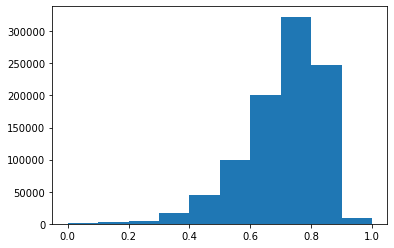

In [26]:
plt.hist(fgen_df.dif.to_list())

(array([  1138.,   3039.,   4381.,  17422.,  44882.,  99777., 200452.,
        322624., 247946.,   9805.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

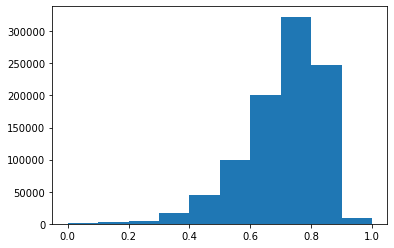

In [27]:
plt.hist(fgen_df.days_passed.to_list())

In [28]:
fgen_df[["datetime", 'days_passed']]

,datetime,days_passed
0,1993-01-01 07:05:42.586394,0.295632
1,1993-01-01 23:02:35.693192,0.664504
2,1993-01-02 17:28:18.608781,0.767858
3,1993-01-03 09:45:02.597772,0.678287
4,1993-01-04 00:52:44.358923,0.630344
...,...,...
951461,1993-05-31 16:14:29.410349,0.523607
951462,1993-06-01 04:22:16.732698,0.505409
951463,1993-06-01 15:03:36.685528,0.445370
951464,1993-06-02 01:14:36.551425,0.424304
